In [2]:
%pylab inline
from astropy.io import fits
import astropy.units as u
import pickle as pickle
import os as os
import pandas as pd

from spectools_ir.utils import extract_hitran_data, spec_convol, make_rotation_diagram, get_molmass
from spectools_ir.utils import compute_thermal_velocity, sigma_to_fwhm, fwhm_to_sigma, wn_to_k, spec_convol_R
from spectools_ir.utils import get_miri_mrs_resolution, get_miri_mrs_wavelengths, make_miri_mrs_figure

from spectools_ir.flux_calculator import calc_fluxes, make_lineshape

from spectools_ir.slabspec import make_spec

from spectools_ir.slab_fitter import Config, LineData,Retrieval
from spectools_ir.slab_fitter import corner_plot, trace_plot, find_best_fit, compute_model_fluxes
from spectools_ir.slab_fitter import calc_solid_angle, calc_radius
from spectools_ir.slab_fitter import read_data_from_file, get_samples

Populating the interactive namespace from numpy and matplotlib


In [3]:
import spectools_ir
spectools_ir.__file__

'C:\\Users\\ksn70\\python\\lib\\site-packages\\spectools_ir\\__init__.py'

get hitran data

In [4]:
hitran_data=extract_hitran_data('CO',4.58,5.2,vup=1)  

Read in disk data and plot

In [12]:
infile='C:\\Users\\ksn70\\mypy\\rawdata\\nirspec_drtau.dat'

wave , flux = np.loadtxt(infile, unpack=True, skiprows=21)
print(wave,flux)

[4.6492472 4.6493402 4.6494331 ... 5.0999174 5.1000195 5.1001215] [1.3894759 1.5901209 1.7907699 ...       nan       nan       nan]


Text(0, 0.5, 'Flux [Jy]')

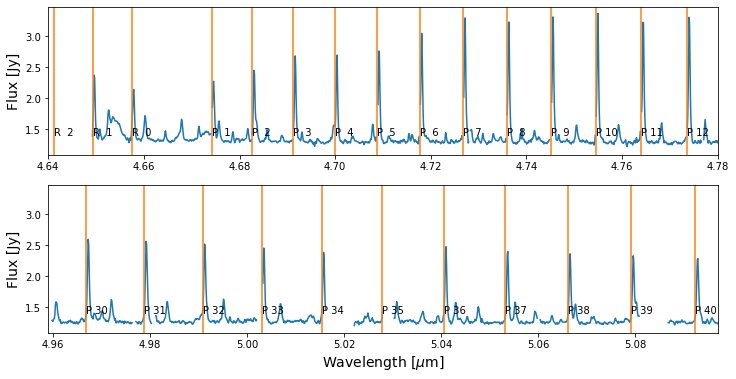

In [6]:
#Plot spectrum.
#The wavelength gap between the two plots is due to a section of poor atmosphere observations

fig=plt.figure(figsize=(12,6))

ax1=fig.add_subplot(211)
ax1.plot(wave,flux)
ax1.set_xlim(4.64,4.78) #first half of wavelength range 
for i,mywave in enumerate(hitran_data['wave']):
    if( (mywave>4.64) & (mywave<4.78) ):
        ax1.axvline(mywave,color='C1')
        ax1.text(hitran_data['wave'][i],1.4,hitran_data['Qpp'][i].strip())
ax1.set_ylabel('Flux [Jy]',fontsize=14)

ax2=fig.add_subplot(212)
ax2.plot(wave,flux)
ax2.set_xlim(4.959,5.097) #second half of wavelength range 
for i,mywave in enumerate(hitran_data['wave']):
    if( (mywave>4.959) & (mywave<5.097) ):
        ax2.axvline(mywave,color='C1')
        ax2.text(hitran_data['wave'][i],1.4,hitran_data['Qpp'][i].strip())
ax2.set_xlabel('Wavelength [$\mu$m]',fontsize=14)
ax2.set_ylabel('Flux [Jy]',fontsize=14)

Not enough data near  5.189179147210439  microns. Skipping.
Not enough data near  5.174955339253712  microns. Skipping.
Not enough data near  5.160884608788992  microns. Skipping.
Not enough data near  5.146965525185513  microns. Skipping.
Not enough data near  5.133196657812509  microns. Skipping.
Not enough data near  5.119576576039213  microns. Skipping.
Not enough data near  5.106104326111781  microns. Skipping.


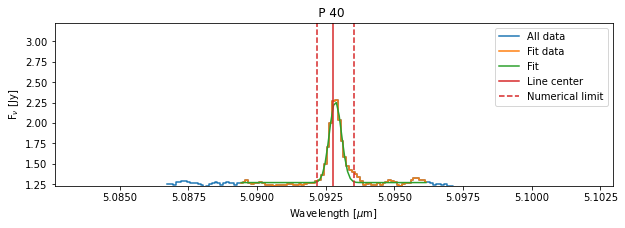

Is this fit okay? [y or n]y


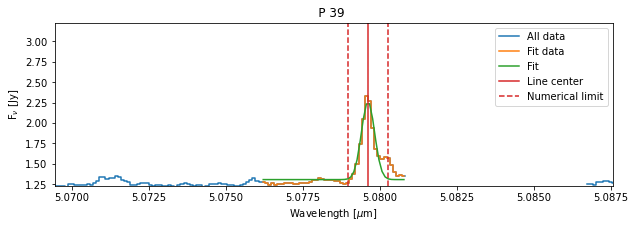

Is this fit okay? [y or n]y


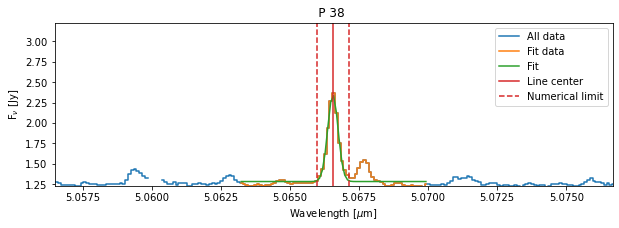

Is this fit okay? [y or n]y


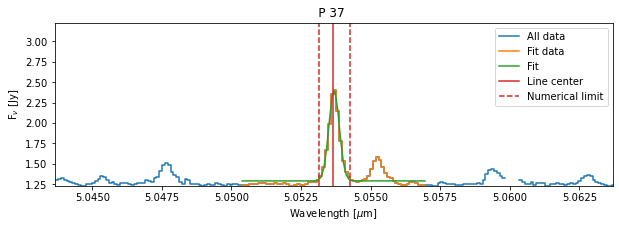

Is this fit okay? [y or n]y


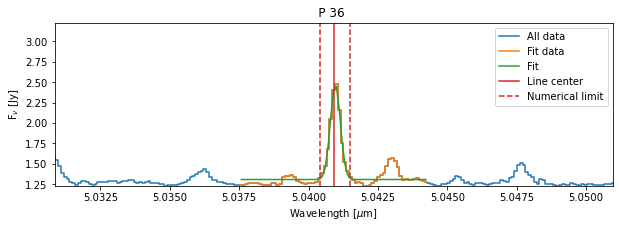

Is this fit okay? [y or n]y


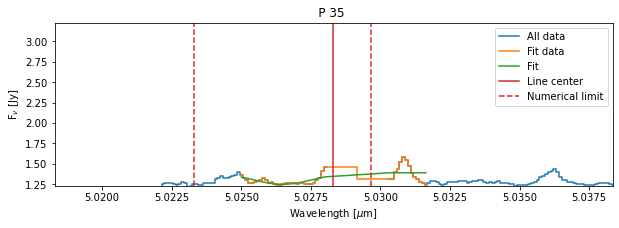

Is this fit okay? [y or n]n


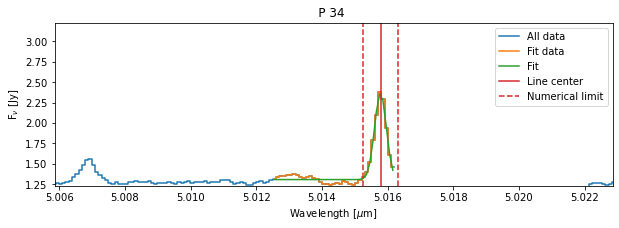

Is this fit okay? [y or n]y


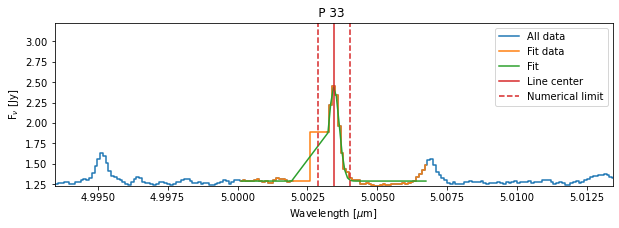

Is this fit okay? [y or n]y


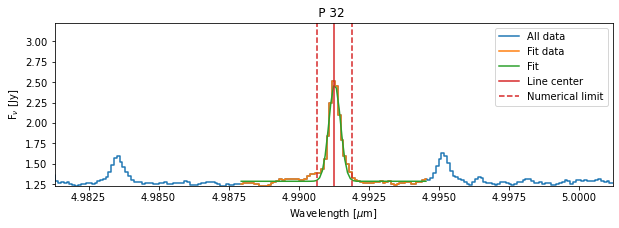

Is this fit okay? [y or n]y


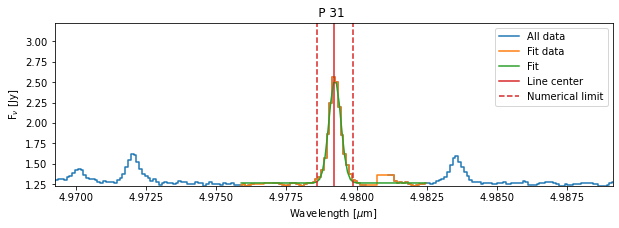

Is this fit okay? [y or n]y


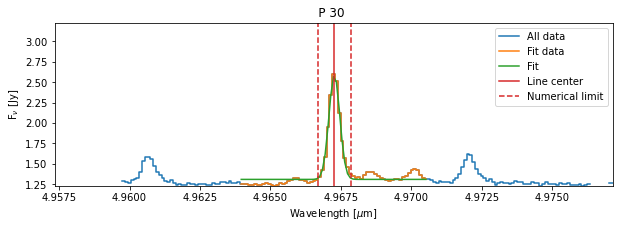

Is this fit okay? [y or n]y
Not enough data near  4.955449368868702  microns. Skipping.
Not enough data near  4.943774944937745  microns. Skipping.
Not enough data near  4.932230708406533  microns. Skipping.
Not enough data near  4.920815705521222  microns. Skipping.
Not enough data near  4.9095285056510445  microns. Skipping.
Not enough data near  4.8983681550421565  microns. Skipping.
Not enough data near  4.887333699940714  microns. Skipping.
Not enough data near  4.876423709715952  microns. Skipping.
Not enough data near  4.865637707490945  microns. Skipping.
Not enough data near  4.854974739511851  microns. Skipping.
Not enough data near  4.844433375147904  microns. Skipping.
Not enough data near  4.834013614399103  microns. Skipping.
Not enough data near  4.823713072880837  microns. Skipping.
Not enough data near  4.813532227470029  microns. Skipping.
Not enough data near  4.803469647535912  microns. Skipping.
Not enough data near  4.793523425570798  microns. Skipping.
Not enough

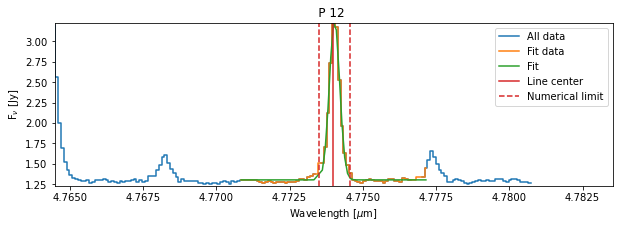

Is this fit okay? [y or n]y


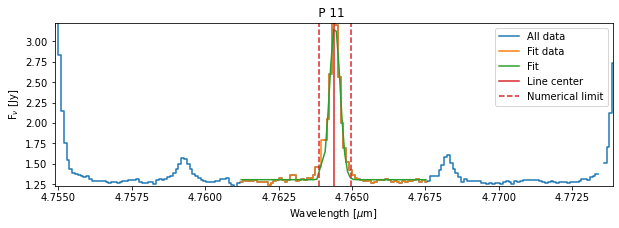

Is this fit okay? [y or n]y


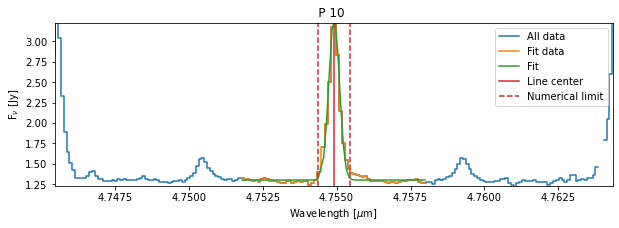

Is this fit okay? [y or n]y


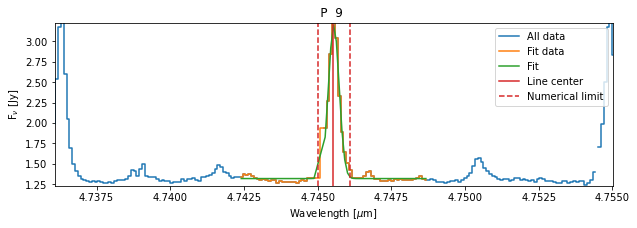

Is this fit okay? [y or n]y


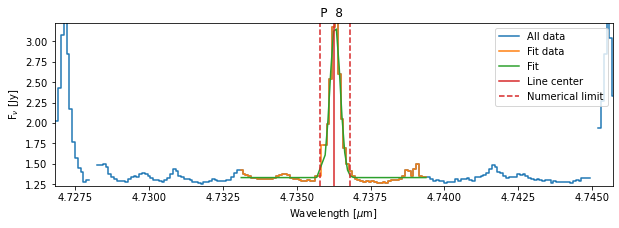

Is this fit okay? [y or n]y


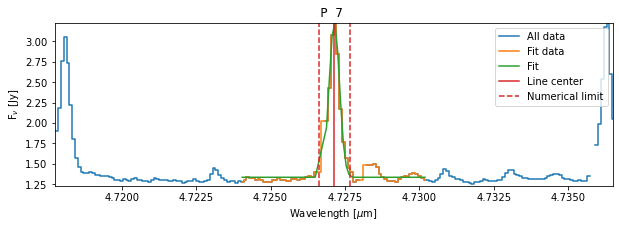

Is this fit okay? [y or n]y


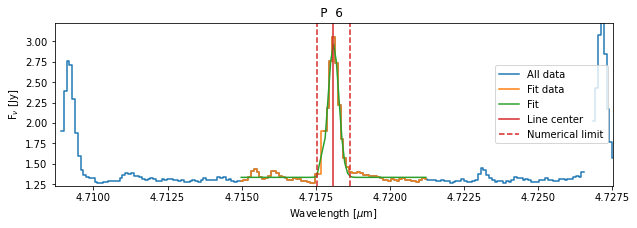

Is this fit okay? [y or n]y


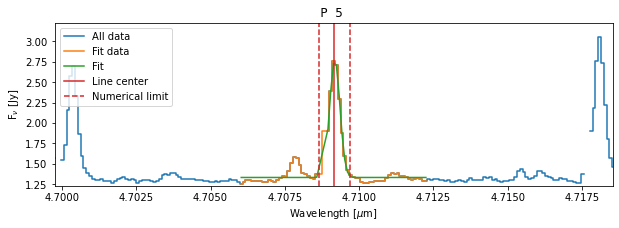

Is this fit okay? [y or n]y


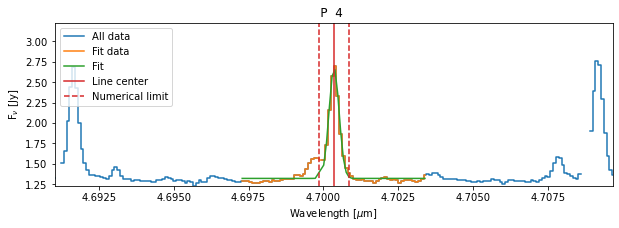

Is this fit okay? [y or n]n


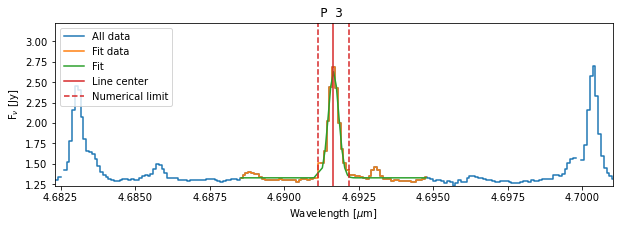

Is this fit okay? [y or n]y


C:\Users\ksn70\python\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\ksn70\python\lib\site-packages\spectools_ir\flux_calculator\helpers.py:188: RuntimeWarning: Mean of empty slice
  dwave=np.nanmean(np.diff(myx[mybool]))


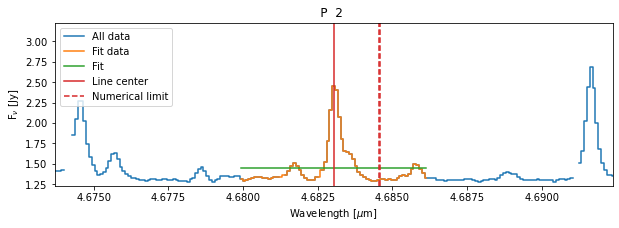

Is this fit okay? [y or n]n


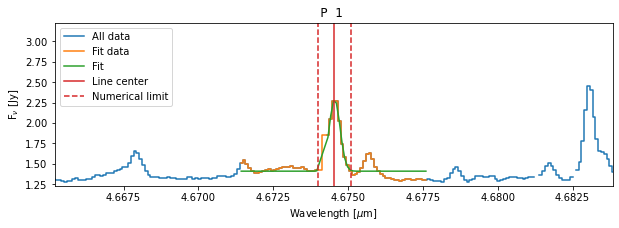

Is this fit okay? [y or n]y


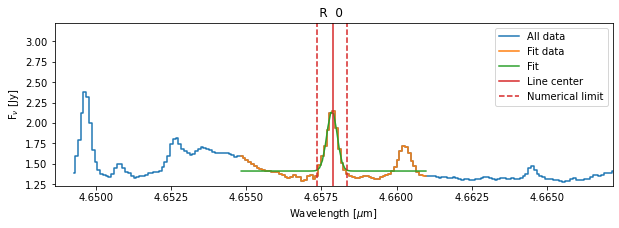

Is this fit okay? [y or n]n


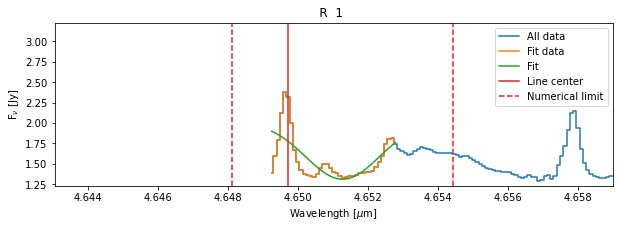

Is this fit okay? [y or n]n
Not enough data near  4.641629065207072  microns. Skipping.
Not enough data near  4.63366283622269  microns. Skipping.
Not enough data near  4.625800566407336  microns. Skipping.
Not enough data near  4.618040825130243  microns. Skipping.
Not enough data near  4.610383135514487  microns. Skipping.
Not enough data near  4.602827497560071  microns. Skipping.
Not enough data near  4.595372957513148  microns. Skipping.
Not enough data near  4.588018561619875  microns. Skipping.
Not enough data near  4.580764309880252  microns. Skipping.


In [7]:
#Calculate fluxes.
#lineflux_data=calc_fluxes(wave,flux,hitran_data, v_dop=25,fwhm_v=40.,sep_v=200.,cont=1.05,vet_fits=True, plot=True)
#pickle.dump(lineflux_data,open('lineflux_data.p','wb')) #save for convenience

lineflux_data=pickle.load(open('lineflux_data.p','rb'))  #restore lineflux_data if you don't want to re-run

In [8]:
lineflux_data

molec_id,local_iso_id,wn,a,elower,Vp_HITRAN,Vpp_HITRAN,Qp_HITRAN,Qpp_HITRAN,gup,glow,nu,eup_k,wave,lineflux,lineflux_Gaussian,lineflux_err,linewidth,linewidth_err,v_dop_fit,v_dop_fit_err,continuum,continuum_err
,,,,,,,,,,,,,,W / m2,,W / m2,km / s,km / s,km / s,km / s,Jy,Jy
int32,int32,float32,float32,float32,bytes15,bytes15,bytes15,bytes15,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64
5,1,1963.7288,13.67,3136.5095,1,0,,P 40,79.0,81.0,58871110000000.0,7338.1045,5.092353,6.586782253100465e-17,6.383251498973935e-17,2.2557913184344847e-18,30.745154668490784,0.8340897188001538,29.291417056677894,0.34261417426610524,1.268036103788094,0.004862768756281566
5,1,1968.8247,13.78,2984.2708,1,0,,P 39,77.0,79.0,59023880000000.0,7126.399,5.079172,6.222435681318153e-17,5.96863022527438e-17,4.88307436176002e-18,29.81380025514896,1.9638815914203505,25.897973097815996,0.7924144514987804,1.3046658185738995,0.013871671331421058
5,1,1973.8915,13.89,2835.7627,1,0,,P 38,75.0,77.0,59175780000000.0,6920.019,5.0661345,5.985039043620385e-17,5.864405391142606e-17,3.7624402653745155e-18,26.293006184861085,1.3927351597630346,24.47250044418883,0.5749846055340427,1.2808208287962792,0.009295337094915031
5,1,1978.9287,13.99,2690.9912,1,0,,P 37,73.0,75.0,59326790000000.0,6718.9727,5.0532393,6.197028027992713e-17,6.123616504449078e-17,3.951245210911555e-18,26.104209998139577,1.3965994893390223,26.663551830802596,0.5765521764527932,1.288495704776626,0.009893012852360269
5,1,1983.9363,14.09,2549.962,1,0,,P 36,71.0,73.0,59476917000000.0,6523.2676,5.0404844,6.244828564555363e-17,6.180557825152134e-17,3.840487334750753e-18,25.111791546107252,1.3165687718140235,28.530736630654697,0.5444518571222877,1.3056540343185172,0.009846109891339695
5,1,1993.8622,14.31,2279.1511,1,0,,P 34,67.0,69.0,59774486000000.0,6147.9116,5.015392,5.687854979107608e-17,5.664149889335373e-17,2.2123624891564514e-18,25.14694318485306,0.8748766633686111,23.30544147843485,0.352227608159143,1.3048347481642275,0.008264501902705756
5,1,1998.7802,14.42,2149.38,1,0,,P 33,65.0,67.0,59921924000000.0,5968.276,5.0030513,6.024413117018929e-17,6.445693898169468e-17,2.5063823239868454e-18,26.294670710694895,1.0337144721595937,23.864376996393997,0.38691064625074045,1.286582139869294,0.006750889404319041
5,1,2003.668,14.52,2023.3715,1,0,,P 32,63.0,65.0,60068456000000.0,5794.0107,4.9908466,7.692365068343046e-17,7.49532901087346e-17,2.4834024755748427e-18,29.491968947666255,0.7650270101012938,26.13055808613405,0.3144608753031528,1.2838844910017733,0.005446476566376108


Text(0, 0.5, 'Line flux [10$^{-16}$ W m$^{-2}$]')

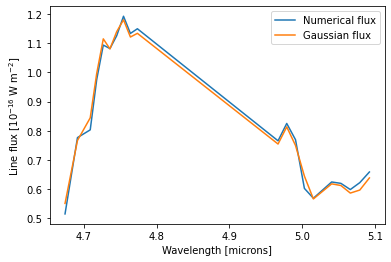

In [9]:
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(lineflux_data['wave'],lineflux_data['lineflux']*1e16, label='Numerical flux')
ax1.plot(lineflux_data['wave'],lineflux_data['lineflux_Gaussian']*1e16 ,label='Gaussian flux')
ax1.legend()
ax1.set_xlabel('Wavelength [microns]')
ax1.set_ylabel(r'Line flux [10$^{-16}$ W m$^{-2}$]')

### Creating "composite lineshape" with info from flux_calculator output

In [10]:
lineshape_data=make_lineshape(wave,flux,lineflux_data)

Text(0, 0.5, 'Arbitrary flux')

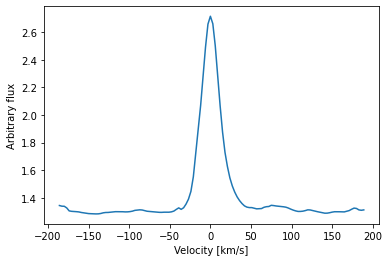

In [11]:
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(lineshape_data[0],lineshape_data[1])

ax1.set_xlabel('Velocity [km/s]')
ax1.set_ylabel('Arbitrary flux')

### "Display resultant fluxes in a rotation diagram"

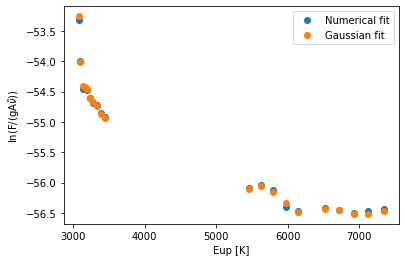

In [12]:
rot_numerical=make_rotation_diagram(lineflux_data,fluxkey='lineflux')
rot_Gaussian=make_rotation_diagram(lineflux_data,fluxkey='lineflux_Gaussian')

fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(rot_numerical['x'],rot_numerical['y'],'C0o',label='Numerical fit')
ax1.plot(rot_Gaussian['x'],rot_Gaussian['y'],'C1o', label='Gaussian fit')

ax1.set_xlabel('Eup [K]')
ax1.set_ylabel(r'ln(F/(gA$\tilde{\nu}$))')
ax1.legend()

### Slabspec

In [13]:
au=1.5e11
#Make slab model
#This can take a few seconds to run.  It is primarily limited by the convolution time.
model_output=make_spec('CO',1e22,1000,np.pi*(0.3*au)**2., wmin=4.64,wmax=5.1,convol_fwhm=30.,d_pc=140.,res=1e-5,vup=1)

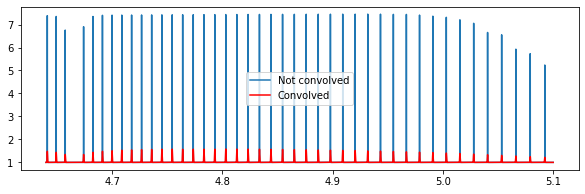

In [14]:
#Plot slab model
fig=plt.figure(figsize=(10,3))
ax1=fig.add_subplot(111)
ax1.plot(model_output['spectrum']['wave'],model_output['spectrum']['flux']+1,label='Not convolved')
ax1.plot(model_output['spectrum']['wave'],model_output['spectrum']['convolflux']+1,'r',label='Convolved')
ax1.legend()

### Output model as rotation diagram

In [15]:
rd_model=make_rotation_diagram(model_output['lineparams'])
rd_data=make_rotation_diagram(lineflux_data)

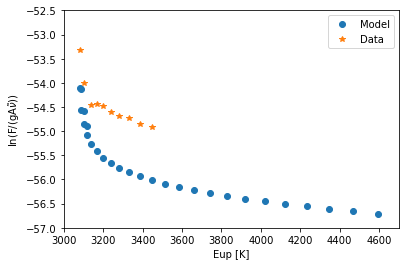

In [16]:
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(rd_model['x'],rd_model['y'],' C0o',label='Model')
ax1.plot(rd_data['x'],rd_data['y'],' C1*',label='Data')
ax1.set_xlabel('Eup [K]')
ax1.set_ylabel(r'ln(F/(gA$\tilde{\nu}$))')
ax1.set_xlim(3000,4700)
ax1.set_ylim(-57,-52.5)
ax1.legend()

### Slab_fitter

In [44]:
myconfig=Config('configdr_tau.json')  #reads config.json by default, or can specify path to file as input parameter
myconfig.display()

data=lineflux_data

mydata=LineData(data)
myretrieval=Retrieval(myconfig,mydata)

{
 "tmin": 1000,
 "tmax": 1600,
 "lognmin": 19,
 "lognmax": 24,
 "logomegamin": -20,
 "logomegamax": -14,
 "Nwalkers": 20,
 "Nburnin": 1000,
 "Nsamples": 3000
}


### Run Retrieval

In [45]:
mychain=myretrieval.run_emcee()  #Run retrieval.  May take a while, depending on number of samples
pickle.dump(mychain,open('test_chain.p','wb'))  #Save for convenience and later retrieval
os.system('afplay /System/Library/Sounds/Sosumi.aiff')

mychain=pickle.load(open('test_chain.p','rb'))  
postsamples=get_samples(mychain,myconfig.getpar('Nburnin'))  #Get list of samples, after removing burnin, from chain

Number of total samples: 60000
Run time [s]: 130.71123480796814


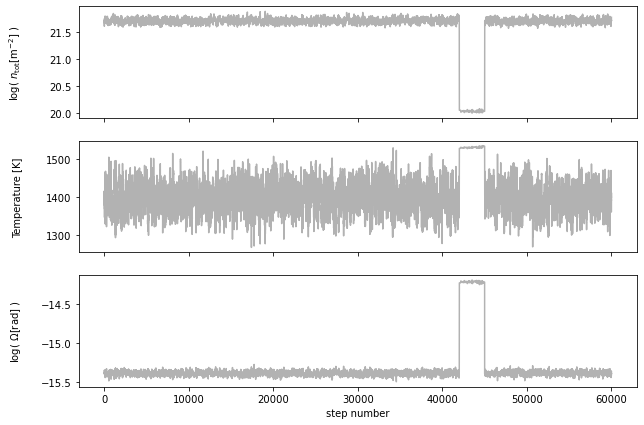

In [50]:
#Trace plot - examine samples
trace_plot(postsamples)

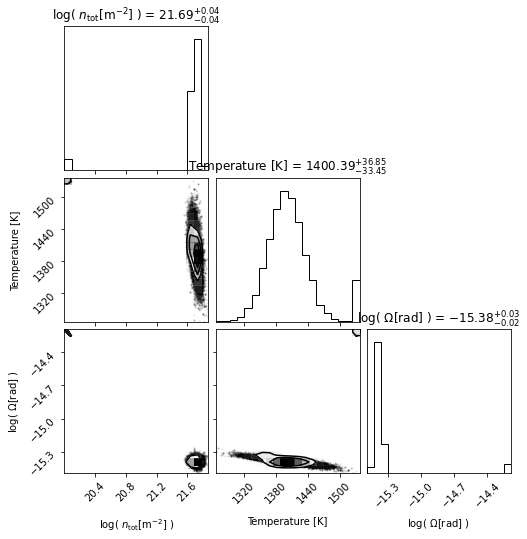

In [47]:
#Corner plot - see posterior distributions
fig=corner_plot(postsamples)

In [48]:
#Best fit parameters - best fit parameters plus/minus 1-sigma intervals
best_fit=find_best_fit(postsamples,show=True)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

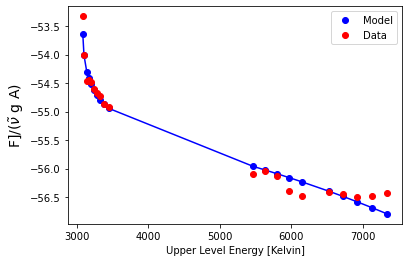

In [49]:
#Rotation diagram
modelflux=compute_model_fluxes(mydata,postsamples) #Compute model fluxes for ecah line in data
rotdiag=mydata.rot_diagram(modelfluxes=modelflux,units='mks') #Rotation diagram for data and model

fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(rotdiag['x'],rotdiag['modely'],'bo',label='Model')
ax1.plot(rotdiag['x'],rotdiag['modely'],'b',label='_None_')
ax1.plot(rotdiag['x'],rotdiag['y'],'ro',label='Data')

ax1.set_xlabel('Upper Level Energy [Kelvin]')
#ax1.set_ylabel(r'F[W m$^{-2}$]/($\~{\nu}$ [m$^{-1}$]g A[s$^{-1}$])',fontsize=14)
ax1.set_ylabel(r'F]/($\~{\nu}$ g A)',fontsize=14)
ax1.legend()